In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import gpjax as gpx
import jax 
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

from gpkan.gpKAN import GPKAN
from test_functions import *
from sklearn.model_selection import train_test_split

plt.style.use([ "science", "grid" ])
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 15})

jax.config.update("jax_enable_x64", True)
key = jr.key(123)

/Users/aaron/Documents/masters/gaussian-process-kan/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


### Test function

In [2]:
f = lambda x, y: goldstein_price(x, y) 

samples = 30
x1, x2 = jnp.meshgrid(jnp.linspace(-2, 2, samples), jnp.linspace(-2 , 2, samples))
X = jnp.stack([x1.flatten(), x2.flatten()]).T
y = jnp.log(f(X[:, 0], X[:, 1])).reshape(-1, 1)
# y = jnp.sqrt(f(X[:, 0], X[:, 1]).reshape(-1, 1))
print(min(y), max(y))
function_name = "goldstein_price"

[1.45449786] [13.83094206]


In [3]:
print(type(jnp.linspace(-2, 2, samples)))

<class 'jaxlib.xla_extension.ArrayImpl'>


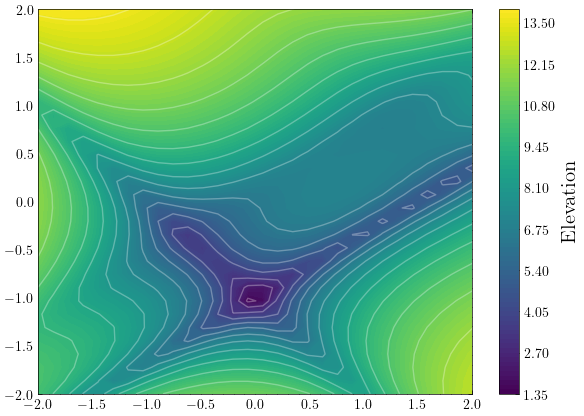

In [4]:
y_grid = y.reshape(samples, samples)
fig_data, ax_data = plt.subplots(figsize=(7, 5))
contour = ax_data.contour(x1, x2, y_grid, levels=15, colors="white", alpha=0.3)
countourf = ax_data.contourf(x1, x2, y_grid, levels=100)
cbar = fig_data.colorbar(countourf, ax=ax_data, label="Elevation")
plt.show()

## Modelling

### Initialize model

In [5]:
model_size = [2, 5, 1]
model_str = '-'.join(str(x) for x in model_size)
model = GPKAN(layers=model_size,
              n_grid_points=10, 
              grid_min=jnp.min(X), 
              grid_max=jnp.max(X), 
              init_paramters=[1.0, 1.0], 
              obs_stddev=0.5
              )

Model initialized.


### Training

In [6]:
def loss_ll(y_true, mean, covariance):
    diag_elements = jnp.diag(covariance)
    covariance_inv = jnp.diag(1.0 / diag_elements)
    log_det = jnp.sum(jnp.log(diag_elements))
    y_true = y_true.flatten()

    return -(-0.5 * (
        y_true.shape[0] * jnp.log(2 * jnp.pi) + 
        log_det + 
        (y_true - mean).T @ covariance_inv @ (y_true - mean)))

In [7]:
def get_learning_rate(epoch, initial_lr=0.0001):
    return initial_lr * (0.95 ** (epoch//50))
get_learning_rate = jax.jit(get_learning_rate)

def clip_gradients(grads, max_norm=1.0):
    grad_norm = jnp.sqrt(sum(jnp.sum(g**2) for g in jax.tree.leaves(grads)))
    clip_factor = jnp.minimum(1.0, max_norm / grad_norm)
    return jax.tree.map(lambda g: g * clip_factor, grads)
clip_gradients = jax.jit(clip_gradients)

In [8]:
val_grad_loss = jax.value_and_grad(
    lambda Xs_latent, ys_latent, kernel_params, X_test, y_test:
        loss_ll(y_test,
                *model.sample_statistics(Xs_latent, ys_latent, X_test, kernel_params, n_samples=10)
                ),
                argnums=(0, 1, 2)
)
val_grad_loss = jax.jit(val_grad_loss)

### Batch-wise training

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

### Optimizing latent support and kernel parameters individually

In [10]:
epochs = 1000
learning_rate = 0.01
loss_history = []

batch_size = 32
patience = 100  # Number of epochs to wait for improvement
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    epoch_losses = []
    current_lr = get_learning_rate(epoch, initial_lr=learning_rate)

    for i in range(0, X_train.shape[0], batch_size):
        batch_X = X_train[i:i+batch_size, :]
        batch_y = y_train[i:i+batch_size, :]

        loss, (grad_grids, grad_supports, grad_params) = val_grad_loss(
            model.latent_grids, 
            model.latent_supports,
            model.kernel_parameters,
            batch_X, batch_y
            )
        print(type(loss))
        break
        
        # Stop training if loss becomes negative
        if loss < 0 or jnp.isnan(loss):
            print(f"Stopping training at epoch {epoch} as loss became negative: {loss}")
            break 

        # grad_supports = clip_gradients(grad_supports)

        model.latent_supports = jax.tree.map(
            lambda latent_supports, grad_supports_: 
            latent_supports - grad_supports_ * current_lr,
            model.latent_supports,
            grad_supports
        )

        epoch_losses.append(loss)

    # Check for improvement
    epoch_loss = np.mean(epoch_losses)
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0 
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}, best loss: {best_loss}")
        break

    loss_history.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss: {epoch_loss:.6f}, LR: {current_lr:.6f}")
    loss_history.append(loss)

/Users/aaron/Documents/masters/gaussian-process-kan/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/aaron/Documents/masters/gaussian-process-kan/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


<class 'jaxlib.xla_extension.ArrayImpl'>
Epoch 0: Loss: nan, LR: 0.010000
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
Epoch 10: Loss: nan, LR: 0.010000
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
Epoch 20: Loss: nan, LR: 0.010000
<class 'jaxlib.xla_extension.ArrayImpl

/Users/aaron/Documents/masters/gaussian-process-kan/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aaron/Documents/masters/gaussian-process-kan/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
Epoch 30: Loss: nan, LR: 0.010000
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
Epoch 40: Loss: nan, LR: 0.010000
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.A

In [10]:
# learning_rate = 0.01
loss_history_params = []

batch_size = 32
patience = 100  # Number of epochs to wait for improvement
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    epoch_losses_params = []
    current_lr = get_learning_rate(epoch, initial_lr=learning_rate)

    for i in range(0, X_train.shape[0], batch_size):
        batch_X = X_train[i:i+batch_size, :]
        batch_y = y_train[i:i+batch_size, :]

        loss, (grad_grids, grad_supports, grad_params) = val_grad_loss(
            model.latent_grids, 
            model.latent_supports,
            model.kernel_parameters,
            batch_X, batch_y
            )
        
        # Stop training if loss becomes negative
        if loss < 0 or jnp.isnan(loss):
            print(f"Stopping training at epoch {epoch} as loss became negative: {loss}")
            break 

        grad_params = clip_gradients(grad_params)

        model.kernel_parameters = jax.tree.map(
            lambda kernel_params, grad_params_:
            kernel_params - grad_params_ * current_lr,
            model.kernel_parameters,
            grad_params 
        )

        epoch_losses_params.append(loss)

    # Check for improvement
    epoch_loss_params = np.mean(epoch_losses_params)
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0 
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}, best loss: {best_loss}")
        break

    loss_history_params.append(epoch_loss_params)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss: {epoch_loss_params:.6f}, LR: {current_lr:.6f}")
    loss_history.append(loss)

2025-06-07 18:04:31.833983: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 14m55.145155s

********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-06-07 18:07:05.640623: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-06-07 18:19:32.858805: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 14m27.224242s

********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Epoch 0: Loss: 66.042679, LR: 0.010000
Epoch 10: Loss: 64.930854, LR: 0.010000
Epoch 20: Loss: 64.495726, LR: 0.010000
Epoch 30: Loss: 64.223331, LR: 0.010000
Epoch 40: Loss: 64.027518, LR: 0.010000
Epoch 50: Loss: 63.864905, LR: 0.009500
Epoch 60: Loss: 63.760610, LR: 0.009500
Epoch 70: Loss: 63.662417, LR: 0.009500
Epoch 80: Loss: 63.574699, LR: 0.009500
Epoch 90: Loss: 63.494177, LR: 0.009500
Epoch 100: Loss: 63.410468, LR: 0.009025
Epoch 110: Loss: 63.335997, LR: 0.009025
Epoch 120: Loss: 63.265982, LR: 0.009025
Epoch 130: Loss: 63.213720, LR: 0.009025
Epoch 140: Loss: 63.177595, LR: 0.009025
Epoch 150: Loss: 63.112150, LR: 0.008574
Epoch 160: Loss: 63.094164, LR: 0.008574
Epoch 170: Loss: 63.056979, LR: 0.008574
Epoch 180: Loss: 63.019916, LR: 0.008574
Epoch 190: Loss: 62.983238, LR: 0.008574
Epoch 200: Loss: 62.940774, LR: 0.008145
Epoch 210: Loss: 62.901394, LR: 0.008145
Epoch 220: Loss: 62.860593, LR: 0.008145
Epoch 230: Loss: 62.807259, LR: 0.008145
Epoch 240: Loss: 62.798669,

### Prediction

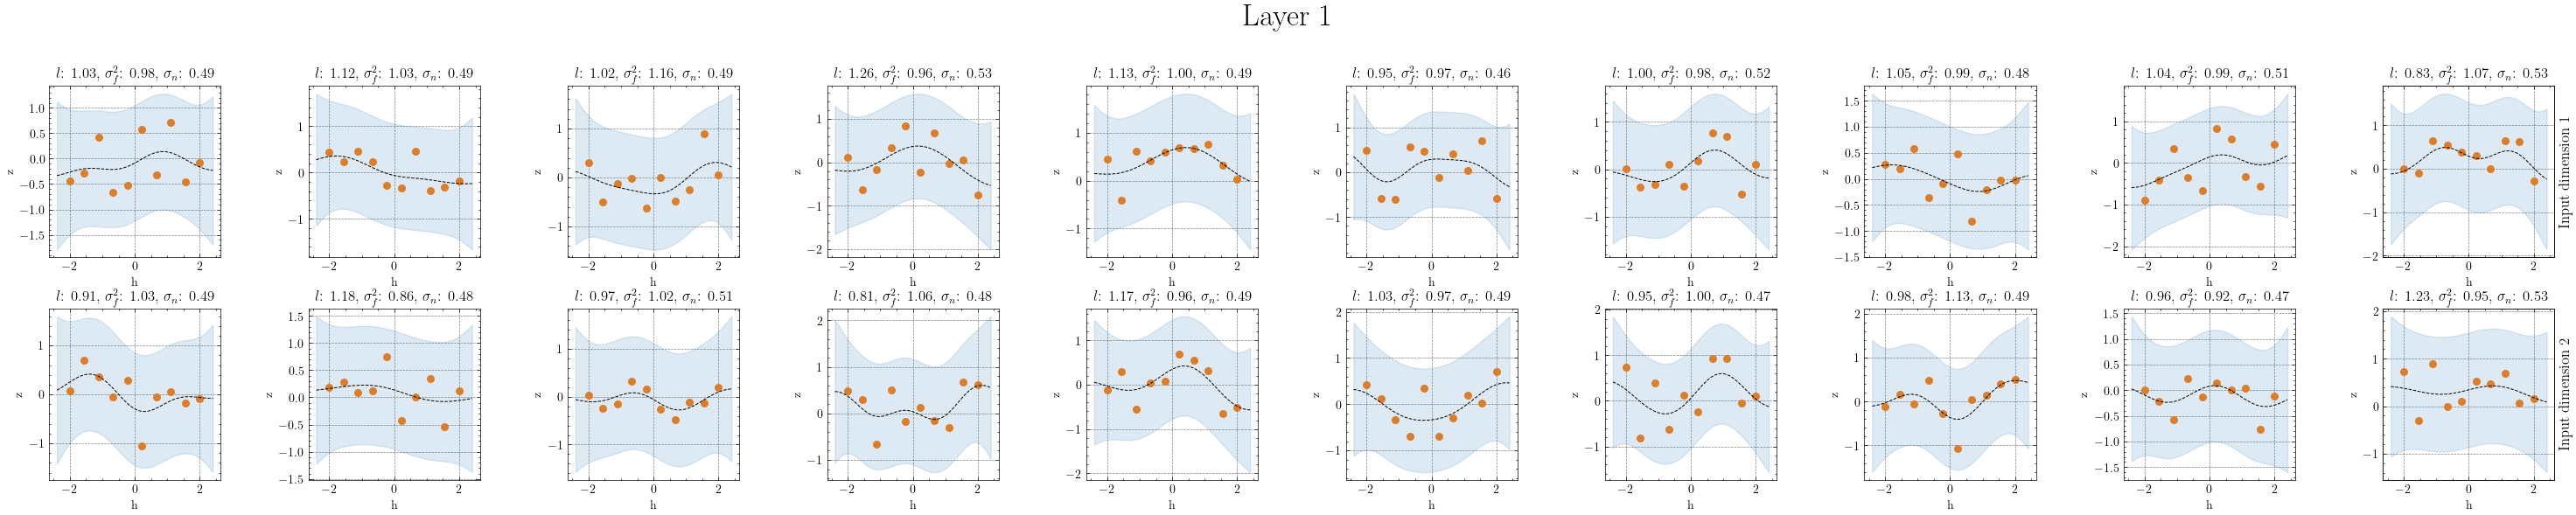

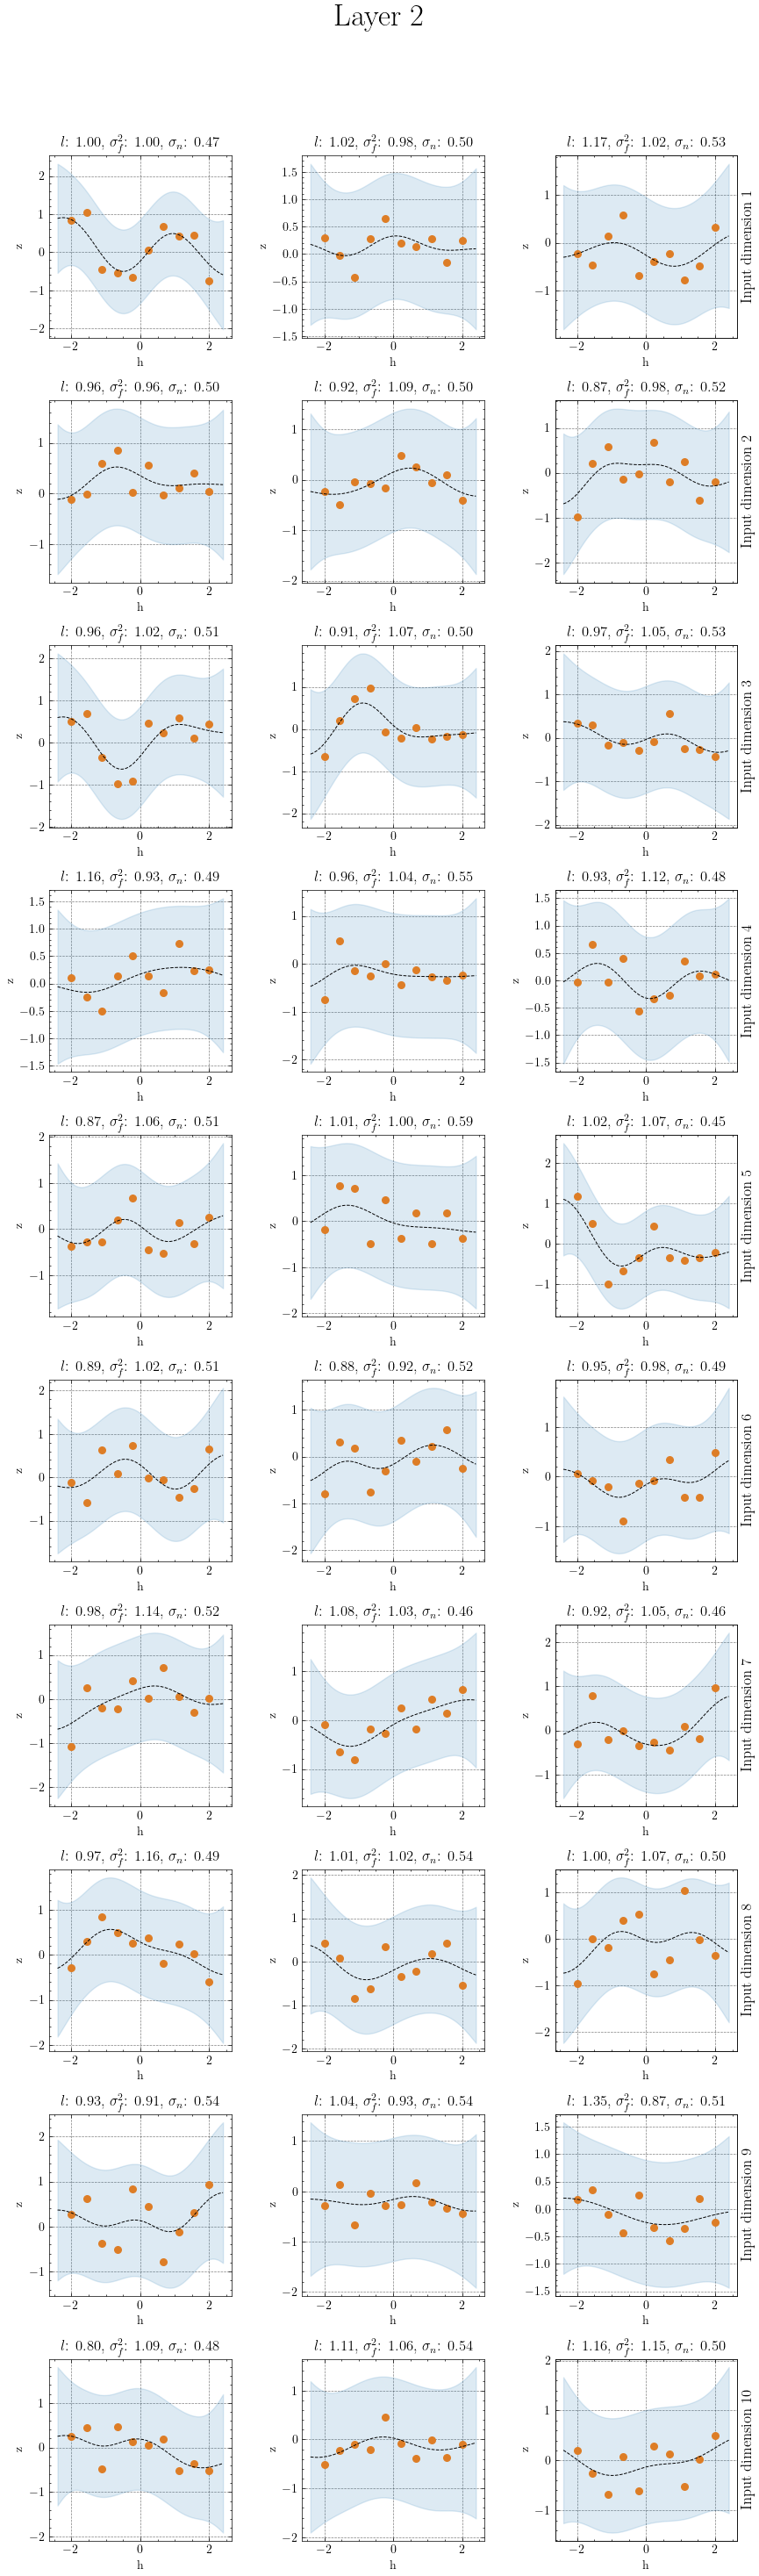

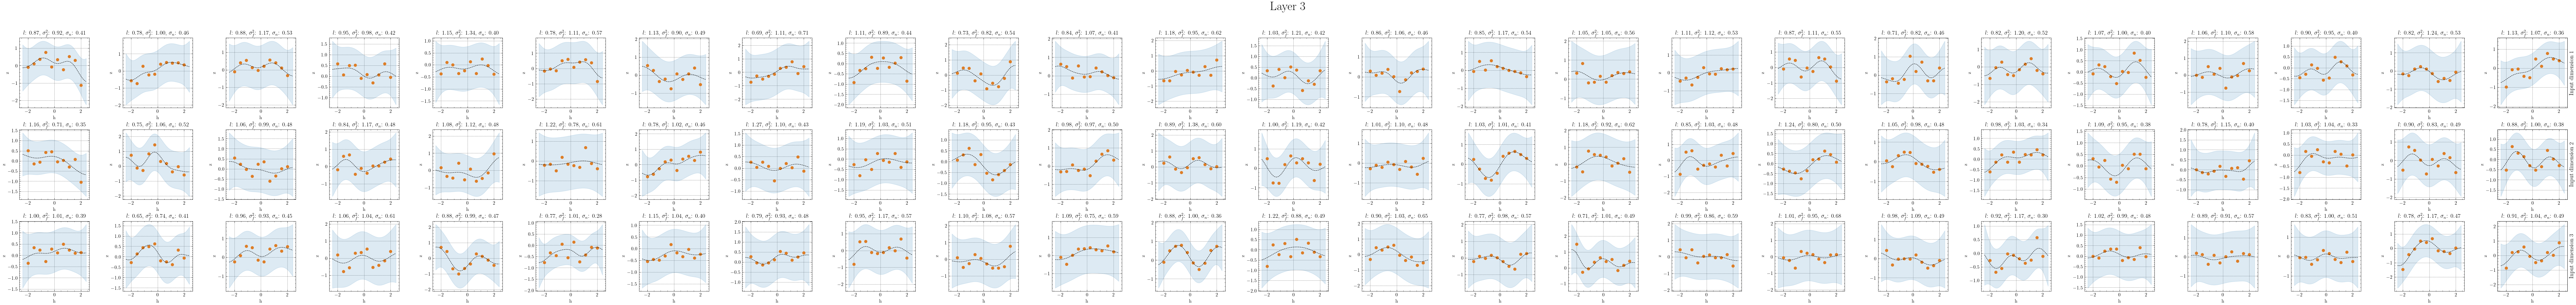

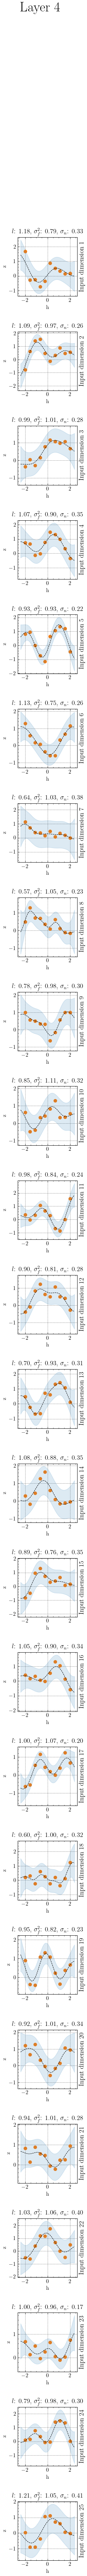

In [11]:
model.plot_neurons(save_fig=True,
                   save_path=f"../results/goldstein_price/figs/{function_name+" "+model_str}")

In [12]:
batch_size = 32 # Adjust as needed
n = X.shape[0]
mu_batches = []
cov_blocks = []

progress_interval = int(n * 0.05)
for i in range(0, n, batch_size):
    X_batch = X[i:i+batch_size]
    mu_batch, cov_batch = model.sample_statistics(
        model.latent_grids, model.latent_supports, X_batch, model.kernel_parameters, 10, key=jr.key(233 + i)
    )
    mu_batches.append(mu_batch)
    cov_blocks.append(cov_batch)
    if (i // batch_size) % (progress_interval // batch_size) == 0:
        percent = int(100 * i / n)
        print(f"{percent}% done predicting...")

mu_full = jnp.concatenate(mu_batches)
cov_full = jax.scipy.linalg.block_diag(*cov_blocks)
y_stddev = jnp.sqrt(jnp.diag(cov_full))

0% done predicting...
3% done predicting...
7% done predicting...
10% done predicting...
14% done predicting...
17% done predicting...
21% done predicting...
24% done predicting...
28% done predicting...
32% done predicting...
35% done predicting...
39% done predicting...
42% done predicting...
46% done predicting...
49% done predicting...
53% done predicting...
56% done predicting...
60% done predicting...
64% done predicting...
67% done predicting...
71% done predicting...
74% done predicting...
78% done predicting...
81% done predicting...
85% done predicting...
88% done predicting...
92% done predicting...
96% done predicting...
99% done predicting...


In [13]:
residuals = y.flatten() - mu_full.flatten()
y_stddev = jnp.sqrt(jnp.diag(cov_full))
# y_sample = jr.multivariate_normal(jr.key(2341), mu_full, cov_full, shape=(1, )).flatten()

<>:91: SyntaxWarning: invalid escape sequence '\%'
<>:91: SyntaxWarning: invalid escape sequence '\%'
/var/folders/3z/fbv_cnz175v2v_9cqnh_3t5r0000gn/T/ipykernel_36819/2321601825.py:91: SyntaxWarning: invalid escape sequence '\%'
  cbar_row2.set_label('Relative Error (\%)')


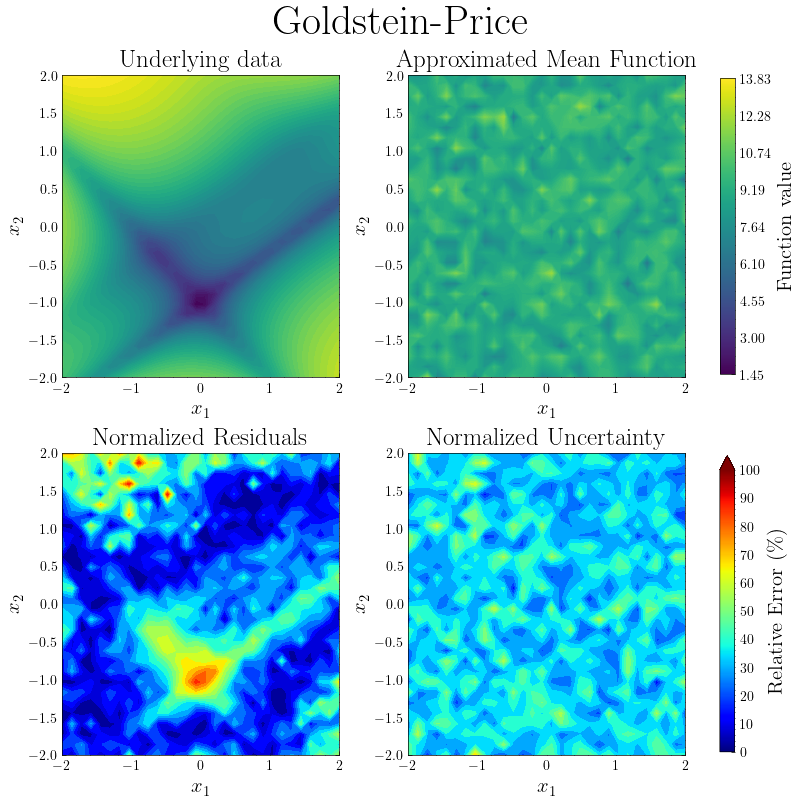

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True)
axs = axs.flatten()

# Determine the min/max values for the original function and mean
vmin = min(y.min(), mu_full.min())
vmax = max(y.max(), mu_full.max())
norm1 = plt.Normalize(vmin, vmax)

# First plot - Actual Function (unchanged)

contourf_test = axs[0].contourf(x1, x2, y.reshape(x2.shape[0], x1.shape[0]), 
                                levels=50,
                                cmap="viridis",
                                vmin=vmin,
                                vmax=vmax
                                )

axs[0].set_title("Underlying data")
axs[0].set_xlabel("$x_1$")
axs[0].set_ylabel("$x_2$")

contourf_pred = axs[1].contourf(x1, x2, mu_full.reshape(x2.shape[0], x1.shape[0]), 
                                cmap="viridis",
                                levels=50,
                                vmin=vmin,
                                vmax=vmax
                                )
                                
axs[1].set_title("Approximated Mean Function")
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("$x_2$")

from matplotlib.cm import ScalarMappable
import numpy as np
sm1 = ScalarMappable(cmap="viridis", norm=norm1)
sm1.set_array([])  # Empty array - using the norm instead
cbar_row1 = fig.colorbar(sm1, ax=[axs[0], axs[1]], location='right', shrink=0.98)
cbar_row1.set_label("Function value")

# Create evenly spaced ticks for the first colorbar
n_ticks = 9  # Number of ticks including min and max
ticks1 = np.linspace(vmin, vmax, n_ticks)
cbar_row1.set_ticks(ticks1)
cbar_row1.set_ticklabels([f"{tick:.2f}" for tick in ticks1])  # Format to 2 decimal places)  # Optional: ensure min/max are shown

# ----------------------------------------------------------------------------------------------------

# Third plot - Normalized Residuals (as percentage of mean)
reshaped_residuals = residuals.reshape(x2.shape[0], x1.shape[0])
epsilon = 1e-10
normalized_residuals = 100 * jnp.abs(reshaped_residuals.flatten()) / (jnp.abs(mu_full.flatten()) + epsilon)
normalizeddev = 100 * (y_stddev.flatten() / (jnp.abs(mu_full.flatten()) + epsilon))

vmin_2 = min(normalized_residuals.min(), normalizeddev.min())
vmax_2 = max(normalized_residuals.max(), normalizeddev.max())
cbar_limit = 100
levels = np.linspace(vmin_2, cbar_limit, 20)
# levels = np.arange(vmin_2, cbar_limit, 25)

contourf_res = axs[2].contourf(x1, x2, normalized_residuals.reshape(x2.shape[0], x1.shape[0]), 
                               levels=levels, 
                               cmap="jet",
                               vmin=vmin_2,
                               vmax=cbar_limit,
                               extend="max",
                               )

axs[2].set_title("Normalized Residuals")
axs[2].set_xlabel("$x_1$")
axs[2].set_ylabel("$x_2$")

contourf_var = axs[3].contourf(x1, x2, normalizeddev.reshape(x2.shape[0], x1.shape[0]), 
                                # levels=50, 
                                levels=levels,
                                cmap="jet",
                                vmin=vmin_2,
                                vmax=cbar_limit,
                                extend="max",
                                )
                                
axs[3].set_title("Normalized Uncertainty")
# axs[3].set_title("Coefficient of Variation")
axs[3].set_xlabel("$x_1$")
axs[3].set_ylabel("$x_2$")

# norm2 = plt.Normalize(vmin_2, vmax_2)  # Create explicit normalization
norm2 = plt.Normalize(vmin_2, cbar_limit)  # Create explicit normalization
sm2 = ScalarMappable(cmap="jet", norm=norm2)
sm2.set_array([])  # Empty array - using the norm instead
cbar_row2 = fig.colorbar(sm2, ax=[axs[2], axs[3]], location='right', shrink=0.98, extend="max")
cbar_row2.set_label('Relative Error (\%)')

# Create evenly spaced ticks for the first colorbar
n_ticks = 9 # Number of ticks including min and max
# ticks2 = np.linspace(vmin_2, vmax_2, n_ticks)
# ticks2 = np.linspace(vmin_2, cbar_limit, n_ticks)
# ticks2 = np.linspace(0, cbar_limit, n_ticks)
ticks2 = np.arange(0, cbar_limit + 1, 10)
cbar_row2.set_ticks(ticks2)
# cbar_row2.set_ticklabels([f"{tick:.1f}" for tick in ticks2])
cbar_row2.set_ticklabels([f"{tick}" for tick in ticks2])

fig.suptitle("Goldstein-Price", fontsize=30, fontweight="bold")

# plt.subplots_adjust(top=0.88)
plt.savefig(f"../results/goldstein_price/figs/{function_name+" "+model_str}_result.png", dpi=500, bbox_inches="tight")
plt.show()